In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
from train_and_test import train, test, validate, prepare_datasets, get_metrics, make_serializeable_metrics, device
import os
import torch

from models._uctransnet.UCTransNet import UCTransNet as Net
import models._uctransnet.Config as uct_config
from torch.nn import BCELoss, CrossEntropyLoss
from losses import DiceLoss, DiceLossWithLogtis
from torch.optim import Adam, SGD

import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


from utils import (
    show_image_and_mask,
    load_config,
    _print,
)

import warnings
warnings.filterwarnings("ignore")

In [3]:
# load config

CONFIG_NAME = "cellpose_uctransnet.yaml"
CONFIG_FILE_PATH = os.path.join("../configs", CONFIG_NAME)

config = load_config(CONFIG_FILE_PATH)

In [4]:
train_dataloader, val_dataloader, test_dataloader = prepare_datasets(config)

In [5]:
train_metrics, valid_metrics, test_metrics = get_metrics(config['model']['params']['n_classes'])

In [6]:
def make_model(config):
    
    config_vit = uct_config.get_CTranS_config()
    model = Net(config_vit, **config['model']['params'])

    torch.cuda.empty_cache()
    model = model.to(device)
    print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

    if config['model']['load_weights']:
        model.load_state_dict(torch.load(model_path))
        print("Loaded pre-trained weights...")
    return model


In [7]:
# define the model 

model = make_model(config)


# prepare output directories
os.makedirs(config['model']['save_dir'], exist_ok=True)
model_path = f"{config['model']['save_dir']}/model_state_dict.pt"

    
# criterion_dice = DiceLoss()
criterion_dice = DiceLossWithLogtis()
# criterion_ce  = BCELoss()
criterion_ce  = CrossEntropyLoss()


def criterion(preds, masks):
    c_dice = criterion_dice(preds, masks)
    c_ce = criterion_ce(preds, masks)
    return 0.5*c_dice + 0.5*c_ce

tr_prms = config['training']
optimizer = globals()[tr_prms['optimizer']['name']](model.parameters(), **tr_prms['optimizer']['params'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', **tr_prms['scheduler'])

Number of parameters: 66430722


In [9]:
best_model, model, res = train(
    model, 
    device, 
    train_dataloader,
    val_dataloader,
    config,
    
    criterion,
    optimizer,
    scheduler,
    train_metrics,
    valid_metrics,
    save_dir = config['model']['save_dir'],
    save_file_id = None,
)

Config:
{
  "run": {
    "mode": "train",
    "device": "gpu"
  },
  "transforms": "none",
  "dataset": {
    "class_name": "nuclei_dataset",
    "input_size": 224,
    "data_dir": "/home/gmahalingam/My.Explorations/datasets/data-science-bowl-2018/data",
    "training": {
      "params": {
        "data_dir": "/home/gmahalingam/My.Explorations/datasets/data-science-bowl-2018/data"
      }
    },
    "validation": {
      "params": {
        "data_dir": "/home/gmahalingam/My.Explorations/datasets/data-science-bowl-2018/data"
      }
    },
    "number_classes": 2
  },
  "data_loader": {
    "train": {
      "batch_size": 8,
      "shuffle": true,
      "num_workers": 8,
      "pin_memory": true
    },
    "validation": {
      "batch_size": 8,
      "shuffle": false,
      "num_workers": 8,
      "pin_memory": true
    },
    "test": {
      "batch_size": 8,
      "shuffle": false,
      "num_workers": 4,
      "pin_memory": false
    }
  },
  "training": {
    "optimizer": {
      "nam

Training) ep:000, batch:0048 -> curr_mean-loss:0.05902, mean_batch-loss:0.22817: : 48it [00:46,  1.03it/s]
Training) ep:001, batch:0048 -> curr_mean-loss:0.05769, mean_batch-loss:0.23810: : 48it [00:46,  1.03it/s]
Training) ep:002, batch:0048 -> curr_mean-loss:0.05695, mean_batch-loss:0.23958: : 48it [00:46,  1.03it/s]
Training) ep:003, batch:0048 -> curr_mean-loss:0.05631, mean_batch-loss:0.19679: : 48it [00:46,  1.02it/s]
Training) ep:004, batch:0048 -> curr_mean-loss:0.05616, mean_batch-loss:0.19305: : 48it [00:47,  1.01it/s]
Training) ep:005, batch:0048 -> curr_mean-loss:0.05593, mean_batch-loss:0.21061: : 48it [00:47,  1.01it/s]
Training) ep:006, batch:0048 -> curr_mean-loss:0.05583, mean_batch-loss:0.19238: : 48it [00:48,  1.00s/it]
Training) ep:007, batch:0048 -> curr_mean-loss:0.05563, mean_batch-loss:0.20906: : 48it [00:48,  1.00s/it]
Training) ep:008, batch:0048 -> curr_mean-loss:0.05620, mean_batch-loss:0.31713: : 48it [00:48,  1.00s/it]
Training) ep:009, batch:0048 -> curr_

In [15]:
config_vit = uct_config.get_CTranS_config()
best_model = Net(config_vit, **config['model']['params'])

torch.cuda.empty_cache()
best_model = best_model.to(device)

fn = "best_model_state_dict.pt"
os.makedirs(config['model']['save_dir'], exist_ok=True)
model_path = f"{config['model']['save_dir']}/{fn}"

best_model.load_state_dict(torch.load(model_path))
print("Loaded best model weights...")

Loaded best model weights...


In [16]:
te_metrics = test(best_model, test_dataloader, test_metrics)
te_metrics.compute()

100%|██████████| 14/14 [00:05<00:00,  2.60it/s]


{'test_metrics/MulticlassF1Score': tensor(0.8500, device='cuda:0'),
 'test_metrics/MulticlassAccuracy': tensor(0.8500, device='cuda:0'),
 'test_metrics/Dice': tensor(0.0334, device='cuda:0'),
 'test_metrics/MulticlassPrecision': tensor(0.8500, device='cuda:0'),
 'test_metrics/MulticlassSpecificity': tensor(0.8500, device='cuda:0'),
 'test_metrics/MulticlassRecall': tensor(0.8500, device='cuda:0'),
 'test_metrics/MulticlassJaccardIndex': tensor(0.4333, device='cuda:0')}

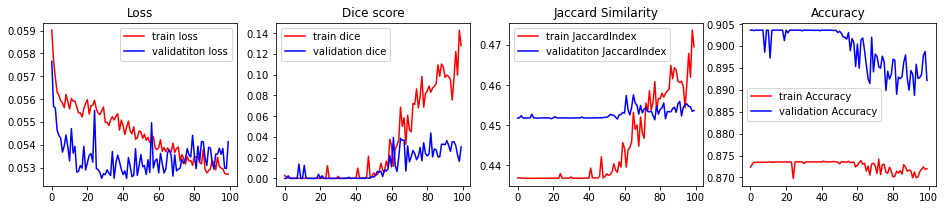

In [19]:
result_file_path = f"{config['model']['save_dir']}/result.json"
with open(result_file_path, 'r') as f:
    results = json.loads(''.join(f.readlines()))
epochs_info = results['epochs_info']

tr_losses = [d['tr_loss'] for d in epochs_info]
vl_losses = [d['vl_loss'] for d in epochs_info]
tr_dice = [d['tr_metrics']['train_metrics/Dice'] for d in epochs_info]
vl_dice = [d['vl_metrics']['valid_metrics/Dice'] for d in epochs_info]
tr_js = [d['tr_metrics']['train_metrics/MulticlassJaccardIndex'] for d in epochs_info]
vl_js = [d['vl_metrics']['valid_metrics/MulticlassJaccardIndex'] for d in epochs_info]
tr_acc = [d['tr_metrics']['train_metrics/MulticlassAccuracy'] for d in epochs_info]
vl_acc = [d['vl_metrics']['valid_metrics/MulticlassAccuracy'] for d in epochs_info]


_, axs = plt.subplots(1, 4, figsize=[16,3])

axs[0].set_title("Loss")
axs[0].plot(tr_losses, 'r-', label="train loss")
axs[0].plot(vl_losses, 'b-', label="validatiton loss")
axs[0].legend()

axs[1].set_title("Dice score")
axs[1].plot(tr_dice, 'r-', label="train dice")
axs[1].plot(vl_dice, 'b-', label="validation dice")
axs[1].legend()

axs[2].set_title("Jaccard Similarity")
axs[2].plot(tr_js, 'r-', label="train JaccardIndex")
axs[2].plot(vl_js, 'b-', label="validatiton JaccardIndex")
axs[2].legend()

axs[3].set_title("Accuracy")
axs[3].plot(tr_acc, 'r-', label="train Accuracy")
axs[3].plot(vl_acc, 'b-', label="validation Accuracy")
axs[3].legend()

plt.show()

In [21]:
from PIL import Image
import cv2
def skin_plot(img, gt, pred):
    img = np.array(img)
    gt = np.array(gt)
    pred = np.array(pred)
    edged_test = cv2.Canny(pred, 100, 255)
    contours_test, _ = cv2.findContours(edged_test, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    edged_gt = cv2.Canny(gt, 100, 255)
    contours_gt, _ = cv2.findContours(edged_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt_test in contours_test:
        cv2.drawContours(img, [cnt_test], -1, (0, 0, 255), 1)
    for cnt_gt in contours_gt:
        cv2.drawContours(img, [cnt_gt], -1, (0,255,0), 1)
    return img

#---------------------------------------------------------------------------------------------


save_imgs_dir = f"{config['model']['save_dir']}/visualized"

if not os.path.isdir(save_imgs_dir):
    os.mkdir(save_imgs_dir)

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        imgs = batch['image']
        msks = batch['mask']
        ids = batch['id']
        
        preds = best_model(imgs.to(device))
        
        txm = imgs.cpu().numpy()
        tbm = torch.argmax(msks, 1).cpu().numpy()
        tpm = torch.argmax(preds, 1).cpu().numpy()
        tid = ids
        
        for idx in range(len(tbm)):
            img = np.moveaxis(txm[idx, :3], 0, -1)*255.
            img = np.ascontiguousarray(img, dtype=np.uint8)
            gt = np.uint8(tbm[idx]*255.)
            pred = np.where(tpm[idx]>0.5, 255, 0)
            pred = np.ascontiguousarray(pred, dtype=np.uint8)
            
            res_img = skin_plot(img, gt, pred)
            
            fid = tid[idx]
            Image.fromarray(img).save(f"{save_imgs_dir}/{fid}_img.png")
            Image.fromarray(res_img).save(f"{save_imgs_dir}/{fid}_img_gt_pred.png")


100%|██████████| 14/14 [00:14<00:00,  1.02s/it]
